In [1]:
import numpy as np
from model_vanilla_zoom import DCGAN
from utils import pp, visualize, to_json, show_all_variables, expand_path, timestamp

import tensorflow as tf
import cv2
import time
import io
import IPython.display
import PIL.Image
import matplotlib.pyplot as plt

In [2]:
def imshow(a, im_size=256, format='png', jpeg_fallback=True, filename=None):
  if a.dtype != np.uint8:
      a = a*255
  a = np.asarray(a, dtype=np.uint8)
  a = cv2.resize(a, (a.shape[1], a.shape[0]))

  str_file = io.BytesIO()
  PIL.Image.fromarray(a).save(str_file, format)
  im_data = str_file.getvalue()
  try:
    disp = IPython.display.display(IPython.display.Image(im_data))
    if filename:
        size = (a.shape[1]//2, a.shape[0]//2)
        im = PIL.Image.fromarray(a)
        im.thumbnail(size,PIL.Image.ANTIALIAS)
        im.save('{}.{}'.format(filename, format))
        
  except IOError:
    if jpeg_fallback and format != 'jpeg':
      print ('Warning: image was too large to display in format "{}"; '
             'trying jpeg instead.').format(format)
      return imshow(a, format='jpeg')
    else:
      raise
  return disp

In [3]:
def imgrid(imarray, cols=5, pad=1):
  if imarray.dtype != np.uint8:
    raise ValueError('imgrid input imarray must be uint8')
  pad = int(pad)
  assert pad >= 0
  cols = int(cols)
  assert cols >= 1
  N, H, W, C = imarray.shape
  rows = int(np.ceil(N / float(cols)))
  batch_pad = rows * cols - N
  assert batch_pad >= 0
  post_pad = [batch_pad, pad, pad, 0]
  pad_arg = [[0, p] for p in post_pad]
  imarray = np.pad(imarray, pad_arg, 'constant', constant_values=255)
  H += pad
  W += pad
  grid = (imarray
          .reshape(rows, cols, H, W, C)
          .transpose(0, 2, 1, 3, 4)
          .reshape(rows*H, cols*H, C))
  if pad:
    grid = grid[:-pad, :-pad]
  return grid

In [4]:
initializer = tf.global_variables_initializer()
config = tf.ConfigProto(log_device_placement=False)
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.run(initializer)

In [5]:
def initialize_uninitialized(sess):
    global_vars          = tf.global_variables()
    is_not_initialized   = sess.run([tf.is_variable_initialized(var) for var in global_vars])
    not_initialized_vars = [v for (v, f) in zip(global_vars, is_not_initialized) if not f]

    print([str(i.name) for i in not_initialized_vars]) # only for testing
    if len(not_initialized_vars):
        sess.run(tf.variables_initializer(not_initialized_vars))
        return not_initialized_vars

In [6]:
checkpoint_dir = "./out/zoom_aug_vanillaG_lr0.0002_new_aug/checkpoint"
sample_dir = "./out/zoom_aug_vanillaG_lr0.0002_new_aug/sample"
num_samples = 10 # 1 sample per digit

flags = tf.app.flags
flags.DEFINE_integer("epoch", 25, "Epoch to train [25]")
flags.DEFINE_float("learning_rate", 0.0002, "Learning rate of for adam [0.0002]")
flags.DEFINE_float("beta1", 0.5, "Momentum term of adam [0.5]")
flags.DEFINE_float("train_size", np.inf, "The size of train images [np.inf]")
flags.DEFINE_integer("batch_size", num_samples, "The size of batch images [64]")
flags.DEFINE_integer("input_height", 28, "The size of image to use (will be center cropped). [108]")
flags.DEFINE_integer("input_width", 28, "The size of image to use (will be center cropped). If None, same value as input_height [None]")
flags.DEFINE_integer("output_height", 28, "The size of the output images to produce [64]")
flags.DEFINE_integer("output_width", 28, "The size of the output images to produce. If None, same value as output_height [None]")
flags.DEFINE_string("dataset", "mnist", "The name of dataset [celebA, mnist, lsun]")
flags.DEFINE_boolean("aug", False, "True for enabling transformation augmentation")
flags.DEFINE_string("input_fname_pattern", "*.jpg", "Glob pattern of filename of input images [*]")
flags.DEFINE_string("data_dir", "./data", "path to datasets [e.g. $HOME/data]")
flags.DEFINE_string("out_dir", "./out", "Root directory for outputs [e.g. $HOME/out]")
flags.DEFINE_string("out_name", "", "Folder (under out_root_dir) for all outputs. Generated automatically if left blank []")
# flags.DEFINE_string("checkpoint_dir", "checkpoint", "Folder (under out_root_dir/out_name) to save checkpoints [checkpoint]")
flags.DEFINE_string("checkpoint_dir", checkpoint_dir, "Folder (under out_root_dir/out_name) to save checkpoints [checkpoint]")
# flags.DEFINE_string("sample_dir", "samples", "Folder (under out_root_dir/out_name) to save samples [samples]")
flags.DEFINE_string("sample_dir", sample_dir, "Folder (under out_root_dir/out_name) to save samples [samples]")
flags.DEFINE_boolean("train", False, "True for training, False for testing [False]")
flags.DEFINE_boolean("crop", False, "True for training, False for testing [False]")
flags.DEFINE_boolean("visualize", False, "True for visualizing, False for nothing [False]")
flags.DEFINE_boolean("export", False, "True for exporting with new batch size")
flags.DEFINE_boolean("freeze", False, "True for exporting with new batch size")
flags.DEFINE_integer("max_to_keep", 1, "maximum number of checkpoints to keep")
flags.DEFINE_integer("sample_freq", 200, "sample every this many iterations")
flags.DEFINE_integer("ckpt_freq", 200, "save checkpoint every this many iterations")
flags.DEFINE_integer("z_dim", 100, "dimensions of z")
flags.DEFINE_integer("y_dim", 10, "choose dimensions of y to be 10")
flags.DEFINE_string("z_dist", "uniform_signed", "'normal01' or 'uniform_unsigned' or uniform_signed")
flags.DEFINE_boolean("G_img_sum", False, "Save generator image summaries in log")
#flags.DEFINE_integer("generate_test_images", 100, "Number of images to generate during test. [100]")
# only for jupyter:
flags.DEFINE_string('f', '', 'kernel')

FLAGS = flags.FLAGS

In [7]:
num_samples = FLAGS.batch_size # this is a bug, DCGAN.y placeholder is fixed to 64 but what if we want 1 sample?
dcgan = DCGAN(
    sess,
    input_width=FLAGS.input_width,
    input_height=FLAGS.input_height,
    output_width=FLAGS.output_width,
    output_height=FLAGS.output_height,
    batch_size=FLAGS.batch_size,
    sample_num=num_samples,
    y_dim=FLAGS.y_dim,
    z_dim=FLAGS.z_dim,
    dataset_name=FLAGS.dataset,
    aug=FLAGS.aug,    
    input_fname_pattern=FLAGS.input_fname_pattern,
    crop=FLAGS.crop,
    checkpoint_dir=FLAGS.checkpoint_dir,
    sample_dir=FLAGS.sample_dir,
    data_dir=FLAGS.data_dir,
    out_dir=FLAGS.out_dir,
    max_to_keep=FLAGS.max_to_keep)

load_success, load_counter = dcgan.load(FLAGS.checkpoint_dir)
if not load_success:
    raise Exception("Checkpoint not found in " + FLAGS.checkpoint_dir)

zoom aug is disabled
loading mnist without augmenting ...
 [*] Reading checkpoints... ./out/zoom_aug_vanillaG_lr0.0002_new_aug/checkpoint
INFO:tensorflow:Restoring parameters from ./out/zoom_aug_vanillaG_lr0.0002_new_aug/checkpoint/model.b64-27200
 [*] Success to read model.b64-27200


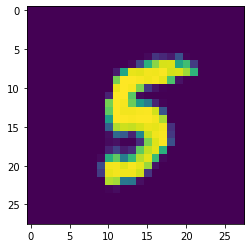

In [8]:
## Testing previously trained G
# visualize(sess, dcgan, FLAGS, 1, FLAGS.sample_dir)
z_sample = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))

y = np.random.choice(FLAGS.y_dim, num_samples)
y_one_hot = np.zeros((num_samples, FLAGS.y_dim))
y_one_hot[np.arange(num_samples), y] = 1

samples = sess.run(dcgan.sampler, feed_dict={dcgan.z: z_sample, dcgan.y: y_one_hot})
plt.imshow(samples[0,:,:,0])

In [9]:
## steerability walk
## define the graph
z_placeholder = tf.placeholder(tf.float32, [None, FLAGS.z_dim], name='z_sample')
y_placeholder = tf.placeholder(tf.float32, [None, FLAGS.y_dim], name='y_sample')

## this will go to get_target and then to the loss
outputs_orig = dcgan.my_sampler(z_placeholder, y_placeholder)

img_size = 28
Nsliders = 1
target = tf.placeholder(tf.float32, shape=(None, img_size, img_size, Nsliders))
mask = tf.placeholder(tf.float32, shape=(None, img_size, img_size, Nsliders))
alpha = tf.placeholder(tf.float32, shape=None)
w = tf.Variable(np.random.uniform(-1, 1, [1, FLAGS.z_dim]), name='walk', dtype=np.float32)

z_new = z_placeholder-tf.log(alpha)*w
y_new = y_placeholder

## this is our transformed
transformed_output = dcgan.my_sampler(z_new, y_new)

loss = tf.losses.compute_weighted_loss(tf.square(transformed_output-target), weights=mask)
lr = 0.005
train_step = tf.train.AdamOptimizer(lr).minimize(loss, var_list=tf.trainable_variables(scope='walk'), 
                                                 name='AdamOpter')

## the graph already contains DCGAN and now we want to init the steerability part in it:
not_initialized_vars = initialize_uninitialized(sess)

['walk:0', 'beta1_power:0', 'beta2_power:0', 'walk/Adam:0', 'walk/Adam_1:0']


In [10]:
def get_target_np(outputs_zs, alpha, show_img=False, show_mask=False):
    
    mask_fn = np.ones(outputs_zs.shape)
    
    if alpha == 1:
        return outputs_zs, mask_fn
    
    new_size = int(alpha*img_size)

    ## crop
    if alpha < 1:
        output_cropped = outputs_zs[:,img_size//2-new_size//2:img_size//2+new_size//2, img_size//2-new_size//2:img_size//2+new_size//2,:]
        mask_cropped = mask_fn
    ## padding
    else:
        output_cropped = np.zeros((outputs_zs.shape[0], new_size, new_size, outputs_zs.shape[3]))
        mask_cropped = np.zeros((outputs_zs.shape[0], new_size, new_size, outputs_zs.shape[3]))
        output_cropped[:, new_size//2-img_size//2:new_size//2+img_size//2, new_size//2-img_size//2:new_size//2+img_size//2,:] = outputs_zs 
        mask_cropped[:, new_size//2-img_size//2:new_size//2+img_size//2, new_size//2-img_size//2:new_size//2+img_size//2,:] = mask_fn
    
    ## Resize
    target_fn = np.zeros(outputs_zs.shape)
    mask_out = np.zeros(outputs_zs.shape)
    for i in range(outputs_zs.shape[0]):
        target_fn[i,:,:,:] = np.expand_dims(cv2.resize(output_cropped[i,:,:,:], (img_size, img_size), interpolation = cv2.INTER_LINEAR), axis=2)
        mask_out[i,:,:,:] = np.expand_dims(cv2.resize(mask_cropped[i,:,:,:], (img_size, img_size), interpolation = cv2.INTER_LINEAR), axis=2)
        
    mask_out[np.nonzero(mask_out)] = 1.
    assert(np.setdiff1d(mask_out, [0., 1.]).size == 0)
    
    if show_img:
        print('Target image:')
        imshow_unscaled(target_fn)
    if show_mask:
        print('Target mask:')
        imshow_unscaled(mask_out)

    return target_fn, mask_out

In [11]:
# ! mkdir -p shift_l2_git/images
# ! mkdir -p shift_l2_git/output
import os
output_dir = './out/argminW/zoom_NoAug_l2_lr{}'.format(lr)
os.makedirs(os.path.join(output_dir, 'images'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'output'), exist_ok=True)
saver = tf.train.Saver(tf.trainable_variables(scope=None))

In [12]:
# This can be train.py

import logging
import sys
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(threadName)-12.12s] [%(levelname)-5.5s]  %(message)s",
    handlers=[
        logging.FileHandler("{0}/{1}.log".format(output_dir, 'train')),
        logging.StreamHandler(sys.stdout)
    ])
logger = logging.getLogger()

alpha_list = []
loss_vals = []

# train
train_sample_size = 20000
def train(saver):
    # init zs
    # we want couple of thousands per category, also compatible with batch_size
    num_samples = train_sample_size
    # sample inputs to feed to placeholders
    zs = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))

    # all categories
    y = np.random.choice(FLAGS.y_dim, num_samples)
    ys = np.zeros((num_samples, FLAGS.y_dim))
    ys[np.arange(num_samples), y] = 1

    Loss_sum = 0;
    n_epoch = 1
    optim_iter = 0
    batch_size = FLAGS.batch_size
    loss_values = []
    Loss_sum_iter = 0  
    
    for epoch in range(n_epoch):
        for batch_start in range(0, num_samples, batch_size):
            start_time = time.time()
            
            coin = np.random.uniform(0, 1)
            if coin <= 0.5:
                alpha_val = np.random.uniform(0.6, 1.) 
            else:
                alpha_val = np.random.uniform(1., 1.67) 

            s = slice(batch_start, min(num_samples, batch_start + batch_size))

            feed_dict_out = {z_placeholder: zs[s], y_placeholder: ys[s]}
            out_zs = sess.run(outputs_orig, feed_dict_out)
            
            target_fn, mask_out = get_target_np(out_zs, alpha_val)#, show_img=True, show_mask=True)

            feed_dict = {z_placeholder: zs[s], y_placeholder: ys[s], alpha: alpha_val, target: target_fn, mask: mask_out}
            curr_loss, _ = sess.run([loss, train_step], feed_dict=feed_dict)

            Loss_sum = Loss_sum + curr_loss
            Loss_sum_iter = Loss_sum_iter + curr_loss
            
            elapsed_time = time.time() - start_time

            logger.info('T, epc, bst, lss, a: {}, {}, {}, {}, {}'.format(elapsed_time, epoch, batch_start, curr_loss, alpha_val))

            alpha_list.append(alpha_val)

            if (optim_iter % 2500 == 0) and (optim_iter > 0):
                saver.save(style_sess, '{}/{}/model_{}.ckpt'.format(output_dir, 'output', optim_iter*batch_size), write_meta_graph=False, write_state=False)
            
            if (optim_iter % 100 == 0) and (optim_iter > 0):
                loss_vals.append(Loss_sum_iter/(100*batch_size))
                Loss_sum_iter = 0
                print('Loss:', loss_vals)

            optim_iter = optim_iter+1
            
    if optim_iter > 0:
        print('average loss with this metric: ', Loss_sum/(optim_iter*batch_size))
    saver.save(sess, '{}/{}/model_{}.ckpt'.format(output_dir, 'output', optim_iter*batch_size), write_meta_graph=False, write_state=False)

In [13]:
train(dcgan.saver)

2019-09-14 13:24:25,802 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.503598690032959, 0, 0, 0.1189841479063034, 0.6472203579107133
2019-09-14 13:24:25,827 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.02031111717224121, 0, 10, 0.06477805227041245, 1.3268087896318332
2019-09-14 13:24:25,840 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008554697036743164, 0, 20, 0.010479718446731567, 0.9815755022674948
2019-09-14 13:24:25,854 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010336637496948242, 0, 30, 0.14170074462890625, 0.6127145854473951
2019-09-14 13:24:25,864 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008876562118530273, 0, 40, 0.08730892091989517, 0.7252242541560228
2019-09-14 13:24:25,876 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009592533111572266, 0, 50, 0.04605468735098839, 1.4911149630515041
2019-09-14 13:24:25,892 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.014537334442138672, 0, 60, 0.017242174595594406, 1.044392562618181
2019-09-14 13:24:25,907 [MainThread  ] 

2019-09-14 13:24:26,928 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.021212339401245117, 0, 600, 0.05781643092632294, 0.7805792434199624
2019-09-14 13:24:26,949 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.017215967178344727, 0, 610, 0.021575406193733215, 0.8725510782455248
2019-09-14 13:24:26,967 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010113954544067383, 0, 620, 0.07490437477827072, 0.7048058712112911
2019-09-14 13:24:26,983 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.015329122543334961, 0, 630, 0.046579793095588684, 1.3044461411665558
2019-09-14 13:24:27,000 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01475834846496582, 0, 640, 0.009634308516979218, 0.9858461789885951
2019-09-14 13:24:27,022 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.020428895950317383, 0, 650, 0.019110282883048058, 1.1099296525861753
2019-09-14 13:24:27,044 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01580190658569336, 0, 660, 0.01702105812728405, 0.9138662271899038
2019-09-14 13:24:27,061 [

2019-09-14 13:24:28,027 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.013115167617797852, 0, 1180, 0.03720911964774132, 1.5331692076411712
2019-09-14 13:24:28,050 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.012238502502441406, 0, 1190, 0.07482192665338516, 0.6494968020849599
2019-09-14 13:24:28,074 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.021485328674316406, 0, 1200, 0.04532739520072937, 0.8209370522163353
2019-09-14 13:24:28,089 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.011812686920166016, 0, 1210, 0.09581141918897629, 0.6233572929166648
2019-09-14 13:24:28,101 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010654211044311523, 0, 1220, 0.045610103756189346, 1.57419737016607
2019-09-14 13:24:28,118 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.015180826187133789, 0, 1230, 0.047658320516347885, 1.6439670463345952
2019-09-14 13:24:28,137 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.012172937393188477, 0, 1240, 0.0975467637181282, 0.6597351612040582
2019-09-14 13:24:28,1

2019-09-14 13:24:29,037 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007879018783569336, 0, 1770, 0.032091956585645676, 0.8428822379140855
2019-09-14 13:24:29,051 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.012291669845581055, 0, 1780, 0.06470906734466553, 0.6825605947284662
2019-09-14 13:24:29,071 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018593311309814453, 0, 1790, 0.04669256880879402, 0.7670089646136529
2019-09-14 13:24:29,084 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01186823844909668, 0, 1800, 0.017678242176771164, 0.863003781286829
2019-09-14 13:24:29,099 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.012974977493286133, 0, 1810, 0.0342128686606884, 1.2959312969680306
2019-09-14 13:24:29,109 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008697271347045898, 0, 1820, 0.0566197969019413, 1.5373217599270532
2019-09-14 13:24:29,124 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009614706039428711, 0, 1830, 0.048179399222135544, 1.4848759173272734
2019-09-14 13:24:29,1

2019-09-14 13:24:29,742 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00937199592590332, 0, 2360, 0.04216797277331352, 1.5991272355417807
2019-09-14 13:24:29,754 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010702133178710938, 0, 2370, 0.017346853390336037, 1.16062100529957
2019-09-14 13:24:29,765 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008533477783203125, 0, 2380, 0.06448075920343399, 0.7578807457782717
2019-09-14 13:24:29,780 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.013359785079956055, 0, 2390, 0.038399748504161835, 0.8391025818442462
2019-09-14 13:24:29,804 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.022531509399414062, 0, 2400, 0.03798101842403412, 0.726242052127309
2019-09-14 13:24:29,828 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.02191019058227539, 0, 2410, 0.042295437306165695, 1.5049889813230697
2019-09-14 13:24:29,840 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00962519645690918, 0, 2420, 0.08709472417831421, 0.630782671093064
2019-09-14 13:24:29,855 

2019-09-14 13:24:30,631 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.029770612716674805, 0, 2950, 0.021551812067627907, 1.2125382016781767
2019-09-14 13:24:30,645 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.012155294418334961, 0, 2960, 0.025881623849272728, 1.300622902425551
2019-09-14 13:24:30,681 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.032164573669433594, 0, 2970, 0.05691700801253319, 1.6279332821414385
2019-09-14 13:24:30,701 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.015287637710571289, 0, 2980, 0.018600769340991974, 1.21838684135215
2019-09-14 13:24:30,723 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.02119278907775879, 0, 2990, 0.051045291125774384, 1.623472387401799
2019-09-14 13:24:30,744 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.016361474990844727, 0, 3000, 0.04539639130234718, 1.4902756859984794
Loss: [0.004178368485358078, 0.00372628245728265, 0.0033328119289753886]
2019-09-14 13:24:30,761 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01452469825744628

2019-09-14 13:24:31,840 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.015717029571533203, 0, 3540, 0.017419951036572456, 0.8952734564264899
2019-09-14 13:24:31,860 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.016043663024902344, 0, 3550, 0.0003075940767303109, 1.0110567285457048
2019-09-14 13:24:31,880 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.011823654174804688, 0, 3560, 0.04173734039068222, 1.331762254980815
2019-09-14 13:24:31,903 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.02061152458190918, 0, 3570, 0.038358576595783234, 1.4392274630850426
2019-09-14 13:24:31,928 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01090693473815918, 0, 3580, 0.01777568645775318, 1.2621997278884716
2019-09-14 13:24:31,941 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010510921478271484, 0, 3590, 0.05385388806462288, 1.518592161030949
2019-09-14 13:24:31,959 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01650524139404297, 0, 3600, 0.0403103232383728, 1.4075108168474824
2019-09-14 13:24:31,97

2019-09-14 13:24:33,045 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.015874862670898438, 0, 4120, 0.032024629414081573, 1.3578517275010957
2019-09-14 13:24:33,068 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.012696504592895508, 0, 4130, 0.01883791945874691, 1.2196663370742467
2019-09-14 13:24:33,086 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.016087770462036133, 0, 4140, 0.036141738295555115, 1.50958987368152
2019-09-14 13:24:33,107 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0178072452545166, 0, 4150, 0.014412780292332172, 0.9267693137041914
2019-09-14 13:24:33,123 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.012476682662963867, 0, 4160, 0.01971314288675785, 0.8697373174475573
2019-09-14 13:24:33,151 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.02657175064086914, 0, 4170, 0.03004050999879837, 1.3353575594734355
2019-09-14 13:24:33,179 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018101930618286133, 0, 4180, 0.08542647212743759, 0.6413212387522038
2019-09-14 13:24:33,19

2019-09-14 13:24:34,096 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.016788244247436523, 0, 4710, 0.037932127714157104, 0.8387232184633848
2019-09-14 13:24:34,115 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01738572120666504, 0, 4720, 0.027673235163092613, 1.2791075600160946
2019-09-14 13:24:34,129 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.012948036193847656, 0, 4730, 0.058587949723005295, 0.7495060251505183
2019-09-14 13:24:34,146 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01575756072998047, 0, 4740, 0.04846250265836716, 0.7538428551147762
2019-09-14 13:24:34,159 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009786128997802734, 0, 4750, 0.04635133221745491, 1.6082168249793827
2019-09-14 13:24:34,173 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.011614561080932617, 0, 4760, 0.01920645870268345, 1.3058729905928228
2019-09-14 13:24:34,192 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.012672185897827148, 0, 4770, 0.07391058653593063, 1.6189340601552482
2019-09-14 13:24:34

2019-09-14 13:24:35,069 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007851123809814453, 0, 5290, 0.04649195075035095, 0.782514164616594
2019-09-14 13:24:35,079 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0060155391693115234, 0, 5300, 0.001961836125701666, 1.0352541526873429
2019-09-14 13:24:35,089 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008327722549438477, 0, 5310, 0.050704460591077805, 0.7965791654267109
2019-09-14 13:24:35,100 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01031041145324707, 0, 5320, 0.008944723755121231, 1.099729477190416
2019-09-14 13:24:35,110 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007660388946533203, 0, 5330, 0.04410284012556076, 0.7725187349123739
2019-09-14 13:24:35,127 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.014416217803955078, 0, 5340, 0.01552520226687193, 1.1306259671099168
2019-09-14 13:24:35,139 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010016679763793945, 0, 5350, 0.051339421421289444, 1.6011424843646798
2019-09-14 13:24:3

2019-09-14 13:24:36,028 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.022897005081176758, 0, 5880, 0.08380575478076935, 0.6376758203584735
2019-09-14 13:24:36,049 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.019481420516967773, 0, 5890, 0.046860065311193466, 1.6511849298136427
2019-09-14 13:24:36,073 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.022922039031982422, 0, 5900, 0.0225816797465086, 1.439909820549671
2019-09-14 13:24:36,111 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0361328125, 0, 5910, 0.025025025010108948, 1.155436207552026
2019-09-14 13:24:36,129 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01601433753967285, 0, 5920, 0.014477865770459175, 1.0466410649925306
2019-09-14 13:24:36,143 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.012769699096679688, 0, 5930, 0.008242071606218815, 0.9376869643370829
2019-09-14 13:24:36,161 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.015822649002075195, 0, 5940, 0.02567119710147381, 1.259786461329175
2019-09-14 13:24:36,185 [Main

2019-09-14 13:24:37,255 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.011931896209716797, 0, 6460, 0.08678610622882843, 0.6145888908910693
2019-09-14 13:24:37,281 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.013607501983642578, 0, 6470, 0.02499629557132721, 1.4332216275230771
2019-09-14 13:24:37,301 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.016582727432250977, 0, 6480, 0.02886921912431717, 0.7947297858042965
2019-09-14 13:24:37,315 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010799884796142578, 0, 6490, 0.0002182549942517653, 1.009986570802101
2019-09-14 13:24:37,329 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00888824462890625, 0, 6500, 0.02072017453610897, 0.8767363013901726
2019-09-14 13:24:37,349 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.012433290481567383, 0, 6510, 0.027781913056969643, 1.5694843625521
2019-09-14 13:24:37,361 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01011204719543457, 0, 6520, 0.039592184126377106, 1.599656567755265
2019-09-14 13:24:37,373

2019-09-14 13:24:38,273 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.015572547912597656, 0, 7040, 0.04027732461690903, 0.772670687706577
2019-09-14 13:24:38,285 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009944677352905273, 0, 7050, 0.02057708613574505, 0.9042901014647206
2019-09-14 13:24:38,296 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009987831115722656, 0, 7060, 0.0508284866809845, 1.4400602420542912
2019-09-14 13:24:38,309 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010386466979980469, 0, 7070, 0.04740944504737854, 1.6397496112952021
2019-09-14 13:24:38,326 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.014734506607055664, 0, 7080, 0.015391262248158455, 0.8654320348059331
2019-09-14 13:24:38,341 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.012230396270751953, 0, 7090, 0.02425238862633705, 1.3661225258117047
2019-09-14 13:24:38,353 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010526180267333984, 0, 7100, 0.03035529889166355, 1.3218611620435035
2019-09-14 13:24:38,3

2019-09-14 13:24:39,312 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.014499425888061523, 0, 7630, 0.0005235967691987753, 1.0167050856382216
2019-09-14 13:24:39,325 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.011966466903686523, 0, 7640, 0.012200833298265934, 1.1496917800406636
2019-09-14 13:24:39,354 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.025372743606567383, 0, 7650, 0.04063710942864418, 0.8176436577182535
2019-09-14 13:24:39,369 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.013310909271240234, 0, 7660, 0.016120463609695435, 1.045182133875549
2019-09-14 13:24:39,395 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.024857759475708008, 0, 7670, 0.048642348498106, 1.5983437680326316
2019-09-14 13:24:39,411 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.013097763061523438, 0, 7680, 0.004732392728328705, 1.0742806990110012
2019-09-14 13:24:39,422 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010074853897094727, 0, 7690, 0.040259815752506256, 0.8442204738231082
2019-09-14 13:24:

2019-09-14 13:24:40,124 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.011318206787109375, 0, 8210, 0.03269718214869499, 1.2949238717066958
2019-09-14 13:24:40,144 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.014544248580932617, 0, 8220, 0.015725497156381607, 0.8706764093561998
2019-09-14 13:24:40,159 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010948419570922852, 0, 8230, 0.047964245080947876, 1.3020431451002523
2019-09-14 13:24:40,179 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.015061140060424805, 0, 8240, 0.037302643060684204, 1.3276815964227655
2019-09-14 13:24:40,197 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.012282371520996094, 0, 8250, 0.014924858696758747, 0.9233345894496787
2019-09-14 13:24:40,216 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.017583847045898438, 0, 8260, 0.030418219044804573, 1.381567728196289
2019-09-14 13:24:40,225 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006971597671508789, 0, 8270, 0.0189504511654377, 0.8596843420013269
2019-09-14 13:24:

2019-09-14 13:24:41,227 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.014358997344970703, 0, 8800, 0.01780383102595806, 0.8968759200956116
2019-09-14 13:24:41,243 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.011929512023925781, 0, 8810, 0.059629812836647034, 0.7458513329699528
2019-09-14 13:24:41,256 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.012149572372436523, 0, 8820, 0.019757376983761787, 1.3008978044298902
2019-09-14 13:24:41,269 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01150202751159668, 0, 8830, 0.02905268594622612, 0.8174550860824141
2019-09-14 13:24:41,305 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.017701148986816406, 0, 8840, 0.00996418297290802, 1.1515749566211813
2019-09-14 13:24:41,318 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.011209487915039062, 0, 8850, 0.028321556746959686, 1.2316800740019747
2019-09-14 13:24:41,337 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.013618707656860352, 0, 8860, 0.008180550299584866, 0.959442323645465
2019-09-14 13:24:4

2019-09-14 13:24:42,303 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010671377182006836, 0, 9370, 0.006735233590006828, 0.9678805442744295
2019-09-14 13:24:42,333 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.02746415138244629, 0, 9380, 0.007443335372954607, 0.971588249489391
2019-09-14 13:24:42,343 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007883071899414062, 0, 9390, 0.006408862769603729, 1.081485016776088
2019-09-14 13:24:42,354 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009583473205566406, 0, 9400, 0.016537459567189217, 0.8699743867952445
2019-09-14 13:24:42,366 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01056051254272461, 0, 9410, 0.03278324007987976, 1.2637268898024692
2019-09-14 13:24:42,377 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008472919464111328, 0, 9420, 0.0308377668261528, 1.2925714109611066
2019-09-14 13:24:42,384 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006758689880371094, 0, 9430, 0.05646777153015137, 0.6971613560490484
2019-09-14 13:24:42,3

2019-09-14 13:24:43,445 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00987553596496582, 0, 9960, 0.08247637003660202, 0.6434750322242808
2019-09-14 13:24:43,461 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.013185977935791016, 0, 9970, 0.0265269186347723, 0.8747939034412313
2019-09-14 13:24:43,495 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.02486276626586914, 0, 9980, 0.017295604571700096, 0.9178056621467467
2019-09-14 13:24:43,537 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.031402587890625, 0, 9990, 0.016720019280910492, 1.1210947651218552
2019-09-14 13:24:43,557 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018200159072875977, 0, 10000, 0.014896266162395477, 1.1534027857656668
Loss: [0.004178368485358078, 0.00372628245728265, 0.0033328119289753886, 0.0039140796626452356, 0.0034966291754244595, 0.003956630009692162, 0.003523029378018691, 0.003444694831734523, 0.0032608182569165366, 0.003312460391833156]
2019-09-14 13:24:43,578 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0

2019-09-14 13:24:44,352 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.011224746704101562, 0, 10520, 0.00522967241704464, 0.9552068837467786
2019-09-14 13:24:44,393 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.03802061080932617, 0, 10530, 0.03418448939919472, 0.8142281206232818
2019-09-14 13:24:44,404 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009252309799194336, 0, 10540, 0.014367928728461266, 0.8895450905411606
2019-09-14 13:24:44,415 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008565425872802734, 0, 10550, 0.01908610574901104, 1.142545148554237
2019-09-14 13:24:44,425 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007710933685302734, 0, 10560, 0.0043126787059009075, 0.9602739769981945
2019-09-14 13:24:44,437 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01066446304321289, 0, 10570, 0.006996495183557272, 0.9764458001906086
2019-09-14 13:24:44,454 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.015973806381225586, 0, 10580, 0.022373709827661514, 0.9125847798656714
2019-09-14 

2019-09-14 13:24:45,217 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008381128311157227, 0, 11090, 0.022376857697963715, 0.8641950546834638
2019-09-14 13:24:45,242 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.02421879768371582, 0, 11100, 0.008821755647659302, 1.1765645868838308
2019-09-14 13:24:45,265 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.017919540405273438, 0, 11110, 0.016002243384718895, 0.9018253051492283
2019-09-14 13:24:45,284 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01851034164428711, 0, 11120, 0.04476561397314072, 1.639533620874251
2019-09-14 13:24:45,305 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018537521362304688, 0, 11130, 0.02075045555830002, 1.2404174397464107
2019-09-14 13:24:45,315 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008150815963745117, 0, 11140, 0.029549788683652878, 1.4842022466914495
2019-09-14 13:24:45,325 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009070634841918945, 0, 11150, 0.017883876338601112, 1.2370667132687552
2019-09-14 

2019-09-14 13:24:46,384 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007941961288452148, 0, 11680, 0.005323580000549555, 1.0819068009951727
2019-09-14 13:24:46,402 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.015418767929077148, 0, 11690, 0.07184506207704544, 0.6239011593643412
2019-09-14 13:24:46,419 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.014242887496948242, 0, 11700, 0.0411994643509388, 0.8515129865528007
2019-09-14 13:24:46,432 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.011397838592529297, 0, 11710, 0.052097052335739136, 1.5901898844087032
2019-09-14 13:24:46,442 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006919145584106445, 0, 11720, 0.038381949067115784, 0.728022805119088
2019-09-14 13:24:46,455 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.012302875518798828, 0, 11730, 0.0454658679664135, 1.607413813069246
2019-09-14 13:24:46,477 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.012950658798217773, 0, 11740, 0.02220972254872322, 1.286940804026792
2019-09-14 13:2

2019-09-14 13:24:47,429 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.022371292114257812, 0, 12250, 0.0036375964991748333, 1.0809197707730123
2019-09-14 13:24:47,439 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00998687744140625, 0, 12260, 0.03765216842293739, 1.574627277261461
2019-09-14 13:24:47,461 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.02074122428894043, 0, 12270, 0.03407645970582962, 0.8051958488750606
2019-09-14 13:24:47,474 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.011745214462280273, 0, 12280, 0.00953010655939579, 0.9873316324262
2019-09-14 13:24:47,484 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00838923454284668, 0, 12290, 0.044522613286972046, 1.5513577284155557
2019-09-14 13:24:47,505 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018105030059814453, 0, 12300, 0.00095643155509606, 1.0295601728481687
2019-09-14 13:24:47,531 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.02070927619934082, 0, 12310, 0.020424578338861465, 1.1141551367448654
2019-09-14 13:24:

2019-09-14 13:24:48,558 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.012213945388793945, 0, 12840, 0.013322628103196621, 0.8855569908907432
2019-09-14 13:24:48,576 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.012442827224731445, 0, 12850, 0.09581031650304794, 0.6288925969116437
2019-09-14 13:24:48,588 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009463310241699219, 0, 12860, 0.049027446657419205, 0.733329893276724
2019-09-14 13:24:48,602 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.012857675552368164, 0, 12870, 0.06410913169384003, 0.7765901311063912
2019-09-14 13:24:48,632 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.028391599655151367, 0, 12880, 0.03439992293715477, 0.8556835304108448
2019-09-14 13:24:48,658 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.021354198455810547, 0, 12890, 0.058209531009197235, 0.750702305286841
2019-09-14 13:24:48,673 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.013177871704101562, 0, 12900, 0.01891474798321724, 0.9220143512736279
2019-09-14 1

2019-09-14 13:24:49,348 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005905866622924805, 0, 13400, 0.032480593770742416, 1.5348828139967088
2019-09-14 13:24:49,354 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005742073059082031, 0, 13410, 0.07442416995763779, 0.6865592018199727
2019-09-14 13:24:49,362 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00629734992980957, 0, 13420, 0.0445219911634922, 1.3975226000849172
2019-09-14 13:24:49,369 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006423234939575195, 0, 13430, 0.046777114272117615, 0.7251112929018722
2019-09-14 13:24:49,375 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005430936813354492, 0, 13440, 0.03611045330762863, 0.8148343786082265
2019-09-14 13:24:49,382 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00541377067565918, 0, 13450, 0.052244286984205246, 0.6791212036343781
2019-09-14 13:24:49,390 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007765293121337891, 0, 13460, 0.03817806765437126, 1.4233116768144125
2019-09-14 13

2019-09-14 13:24:50,150 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.016024351119995117, 0, 13990, 0.04358146712183952, 0.7305345479721486
2019-09-14 13:24:50,195 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.028792381286621094, 0, 14000, 0.01910541206598282, 1.184458694103387
Loss: [0.004178368485358078, 0.00372628245728265, 0.0033328119289753886, 0.0039140796626452356, 0.0034966291754244595, 0.003956630009692162, 0.003523029378018691, 0.003444694831734523, 0.0032608182569165366, 0.003312460391833156, 0.0031967112106503917, 0.0034011644999409328, 0.0029835453455634704, 0.0035403614723472855]
2019-09-14 13:24:50,215 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.014885425567626953, 0, 14010, 0.02198660746216774, 1.1101692351755434
2019-09-14 13:24:50,249 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.02172541618347168, 0, 14020, 0.07790130376815796, 0.7188462657877146
2019-09-14 13:24:50,278 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018847942352294922, 0, 14030, 0.0394552350044

2019-09-14 13:24:51,223 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01106715202331543, 0, 14550, 0.052279431372880936, 0.7348367835718936
2019-09-14 13:24:51,235 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009534120559692383, 0, 14560, 0.0035487315617501736, 0.9440787784404898
2019-09-14 13:24:51,262 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.026896238327026367, 0, 14570, 0.013504157774150372, 1.1405636604449831
2019-09-14 13:24:51,275 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009101152420043945, 0, 14580, 0.00991404801607132, 0.9913797680104964
2019-09-14 13:24:51,294 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01698446273803711, 0, 14590, 0.00480773625895381, 0.9670965164120287
2019-09-14 13:24:51,315 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.016507625579833984, 0, 14600, 0.02780616283416748, 0.8424641719533109
2019-09-14 13:24:51,339 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.021969079971313477, 0, 14610, 0.031477220356464386, 0.8047628927245934
2019-09-14

2019-09-14 13:24:52,396 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009517192840576172, 0, 15110, 0.01864028349518776, 0.8589380364487106
2019-09-14 13:24:52,419 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.015978097915649414, 0, 15120, 0.006943920161575079, 0.9850257045201668
2019-09-14 13:24:52,437 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.016158342361450195, 0, 15130, 0.03195900470018387, 0.7882620982316519
2019-09-14 13:24:52,469 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.031485557556152344, 0, 15140, 0.0028861055616289377, 1.0340318672261126
2019-09-14 13:24:52,486 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.013884544372558594, 0, 15150, 0.004985929466784, 0.9318642896693087
2019-09-14 13:24:52,497 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010151147842407227, 0, 15160, 0.005011602770537138, 1.086655817127034
2019-09-14 13:24:52,517 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.018605947494506836, 0, 15170, 0.029333725571632385, 1.5187859321828667
2019-09-14 

2019-09-14 13:24:53,464 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.011121988296508789, 0, 15700, 0.017171980813145638, 0.8801206211305193
2019-09-14 13:24:53,484 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01571822166442871, 0, 15710, 0.006489393766969442, 1.1581923689416254
2019-09-14 13:24:53,506 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.020529985427856445, 0, 15720, 0.006995160132646561, 0.9414569411931902
2019-09-14 13:24:53,525 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.014976739883422852, 0, 15730, 0.05269581452012062, 1.5152133821375608
2019-09-14 13:24:53,544 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.014589071273803711, 0, 15740, 0.03289054334163666, 1.5489231720312588
2019-09-14 13:24:53,578 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.03268742561340332, 0, 15750, 0.08461708575487137, 0.6357574335441697
2019-09-14 13:24:53,595 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.015502691268920898, 0, 15760, 0.03917543962597847, 1.6641089370143587
2019-09-14 1

2019-09-14 13:24:54,233 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006906747817993164, 0, 16260, 0.03417191654443741, 0.8276580339963258
2019-09-14 13:24:54,242 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008426666259765625, 0, 16270, 0.017631661146879196, 1.065482625695313
2019-09-14 13:24:54,253 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010067462921142578, 0, 16280, 0.019679082557559013, 1.2499812607046803
2019-09-14 13:24:54,264 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009412050247192383, 0, 16290, 0.013581205159425735, 0.8730298247030992
2019-09-14 13:24:54,277 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00872802734375, 0, 16300, 0.018616173416376114, 0.864454287129341
2019-09-14 13:24:54,291 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.012886524200439453, 0, 16310, 0.031067660078406334, 0.8357745949270571
2019-09-14 13:24:54,308 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.012019157409667969, 0, 16320, 0.026021834462881088, 1.3588895515367574
2019-09-14 13

2019-09-14 13:24:55,187 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.026058435440063477, 0, 16850, 0.02039944939315319, 1.2179894160767546
2019-09-14 13:24:55,211 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.022344112396240234, 0, 16860, 0.012814026325941086, 1.1588740839461156
2019-09-14 13:24:55,218 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005945444107055664, 0, 16870, 0.041865285485982895, 1.3301212730944072
2019-09-14 13:24:55,226 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007767915725708008, 0, 16880, 0.012360276654362679, 1.1541416010678542
2019-09-14 13:24:55,240 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.012131929397583008, 0, 16890, 0.028454110026359558, 0.8325142638179618
2019-09-14 13:24:55,255 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010437726974487305, 0, 16900, 0.06311754882335663, 0.6908318694763249
2019-09-14 13:24:55,285 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.016356945037841797, 0, 16910, 0.04816509410738945, 1.501556858995468
2019-09-14

2019-09-14 13:24:56,272 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.021582365036010742, 0, 17410, 0.028846582397818565, 1.2282194942458244
2019-09-14 13:24:56,286 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.012725591659545898, 0, 17420, 0.0775785967707634, 0.6785344499846404
2019-09-14 13:24:56,298 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009521484375, 0, 17430, 0.03725272789597511, 1.594723530093664
2019-09-14 13:24:56,312 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0096282958984375, 0, 17440, 0.040666304528713226, 1.3982276868449732
2019-09-14 13:24:56,328 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.011835813522338867, 0, 17450, 0.015588709153234959, 1.0629202028377038
2019-09-14 13:24:56,344 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.014679670333862305, 0, 17460, 0.0688149631023407, 0.609385784471901
2019-09-14 13:24:56,362 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.015294551849365234, 0, 17470, 0.02887077070772648, 1.4215581364946293
2019-09-14 13:24:56,38

2019-09-14 13:24:57,369 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.013203144073486328, 0, 18000, 0.038242634385824203, 1.4138105319232641
Loss: [0.004178368485358078, 0.00372628245728265, 0.0033328119289753886, 0.0039140796626452356, 0.0034966291754244595, 0.003956630009692162, 0.003523029378018691, 0.003444694831734523, 0.0032608182569165366, 0.003312460391833156, 0.0031967112106503917, 0.0034011644999409328, 0.0029835453455634704, 0.0035403614723472855, 0.00320404233422596, 0.0027451227872606976, 0.003288549527524083, 0.0035017967308122026]
2019-09-14 13:24:57,410 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.021506547927856445, 0, 18010, 0.06794215738773346, 0.6513014979637749
2019-09-14 13:24:57,425 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.013327598571777344, 0, 18020, 0.009191771037876606, 0.9828252475115328
2019-09-14 13:24:57,447 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.020740270614624023, 0, 18030, 0.023485926911234856, 0.8669097452453615
2019-09-14 13:24:57,46

2019-09-14 13:24:58,381 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01687765121459961, 0, 18550, 0.023159034550189972, 1.3381094152279993
2019-09-14 13:24:58,401 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.017586231231689453, 0, 18560, 0.09330669790506363, 0.6765744592725782
2019-09-14 13:24:58,411 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009952068328857422, 0, 18570, 0.029100099578499794, 1.2690885902959868
2019-09-14 13:24:58,422 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008880138397216797, 0, 18580, 0.007548327557742596, 0.9724586534080932
2019-09-14 13:24:58,437 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.013283729553222656, 0, 18590, 0.03131398558616638, 1.3264243827546283
2019-09-14 13:24:58,447 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008022785186767578, 0, 18600, 0.008320216089487076, 1.083223886805327
2019-09-14 13:24:58,465 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.016270875930786133, 0, 18610, 0.011941727250814438, 0.8777040924754804
2019-09-14

2019-09-14 13:24:58,995 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008347034454345703, 0, 19100, 0.014440382830798626, 1.1667443292663666
2019-09-14 13:24:59,002 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006531476974487305, 0, 19110, 0.09103970974683762, 0.6170099769511784
2019-09-14 13:24:59,010 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006644487380981445, 0, 19120, 0.006673693656921387, 0.9415096564261036
2019-09-14 13:24:59,016 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0058705806732177734, 0, 19130, 0.018450720235705376, 1.2357457974326458
2019-09-14 13:24:59,028 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010273933410644531, 0, 19140, 0.005985421594232321, 0.9971215637791058
2019-09-14 13:24:59,042 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01386117935180664, 0, 19150, 0.02049616537988186, 0.911594716742159
2019-09-14 13:24:59,061 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01615762710571289, 0, 19160, 0.06830081343650818, 0.604731311111798
2019-09-14 1

2019-09-14 13:24:59,933 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.011010169982910156, 0, 19690, 0.02651768922805786, 1.3234843519790684
2019-09-14 13:24:59,950 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.015290260314941406, 0, 19700, 0.01804899051785469, 0.8705385335444249
2019-09-14 13:24:59,962 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008216142654418945, 0, 19710, 0.04494469612836838, 1.487814502744948
2019-09-14 13:24:59,976 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.011745214462280273, 0, 19720, 0.031210169196128845, 1.4451644833588357
2019-09-14 13:24:59,991 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009742021560668945, 0, 19730, 0.07504881173372269, 0.6083004666391055
2019-09-14 13:25:00,009 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.011252164840698242, 0, 19740, 0.030196426436305046, 1.4122916346058443
2019-09-14 13:25:00,026 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.012513160705566406, 0, 19750, 0.06962232291698456, 0.6070553042334352
2019-09-14 1

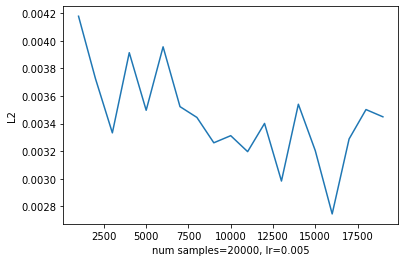

[0.004178368485358078, 0.00372628245728265, 0.0033328119289753886, 0.0039140796626452356, 0.0034966291754244595, 0.003956630009692162, 0.003523029378018691, 0.003444694831734523, 0.0032608182569165366, 0.003312460391833156, 0.0031967112106503917, 0.0034011644999409328, 0.0029835453455634704, 0.0035403614723472855, 0.00320404233422596, 0.0027451227872606976, 0.003288549527524083, 0.0035017967308122026, 0.003449177146976581]


In [14]:
import matplotlib.pyplot as plt
loss_vals_x = np.arange(FLAGS.batch_size*100, train_sample_size, FLAGS.batch_size*100)
plt.plot(loss_vals_x, loss_vals)
plt.xlabel('num samples={}, lr={}'.format(train_sample_size, lr))
plt.ylabel('L2')
plt.show()
print(loss_vals)

In [15]:
# test: show imgs 
# Need work:
# saver.restore(sess, "./out/argminW/zoom_NoAug_l2_lr0.005/output/model_20000.ckpt")

[0.5        0.55555556 0.625      0.71428571 0.83333333 1.
 1.2        1.4        1.6        1.8        2.        ]


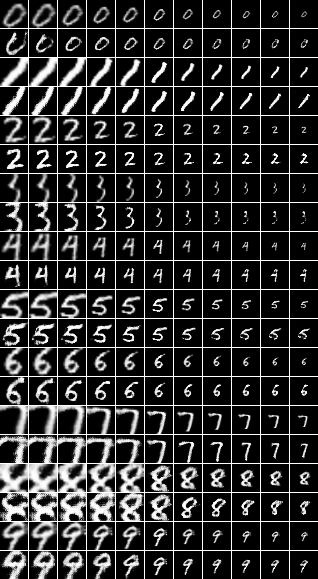

In [16]:
num_samples = 10

a = np.array([1.2, 1.4, 1.6, 1.8, 2.])
np.reciprocal(a[::-1])
b=[np.reciprocal(a[::-1]),np.array([1]),a]
a = np.concatenate(b)

zs = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))
y = np.arange(0,FLAGS.y_dim,1)
ys = np.zeros((num_samples, FLAGS.y_dim))
ys[np.arange(num_samples), y] = 1

im_targets = []
im_transformed = []
for i in range(a.shape[0]):
    feed_dict_out = {z_placeholder: zs, y_placeholder: ys}
    out_zs = sess.run(outputs_orig, feed_dict_out)
    target_fn, mask_out = get_target_np(out_zs, a[i])#, show_img=True, show_mask=True)
    im_targets.append(target_fn)
    ## get transformed:
    feed_dict = {z_placeholder: zs, y_placeholder: ys, alpha: a[i], target: target_fn, mask: mask_out}
    samples = sess.run(transformed_output, feed_dict=feed_dict)
    im_transformed.append(samples)
#     imshow(imgrid(np.uint8(samples*255), cols=1))

ims = []
for j in range(FLAGS.y_dim):
    ims.append(np.stack([x[j, :, :, :] for x in im_targets], axis=0))
    ims.append(np.stack([x[j, :, :, :] for x in im_transformed], axis=0))

print(a)
imshow(imgrid(np.uint8(np.concatenate(ims)*255), cols=a.shape[0]))

In [17]:
loss_l2_sample = tf.reduce_sum(tf.multiply(tf.square(transformed_output-target), mask), axis=(1,2,3)) \
        / tf.reduce_sum(mask, axis=(1,2,3))

loss_l2_trained = loss

In [18]:
import logging
import sys
# import argparse
# from utils import *
# import graphs
# import constants
import time
import pdb
import os
# import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 14})
rc('text', usetex=True)

num_samples = 10000
vocab_size = FLAGS.y_dim
batch_size = FLAGS.batch_size

z_sample = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))
y = np.arange(0,FLAGS.y_dim,1)
y_one_hot = np.zeros((len(y), FLAGS.y_dim))
y_one_hot[np.arange(len(y)), y] = 1
y_one_hot = np.tile(y_one_hot,[num_samples,1])

zs = z_sample
ys = y_one_hot
alphas = a 
alphas_no_log = a

# get alphas list
# if type(g) == graphs.ZoomTransform:
#     alp = np.linspace(1, opt.max_alpha, opt.num_alphas//2 + 1)
#     b = 1/alp
#     alphas = np.concatenate((np.delete(b[::-1], -1), alp), axis=0)
#     alphas = alphas[::-1]
# else:
#     alphas = np.linspace(-opt.max_alpha, opt.max_alpha, opt.num_alphas)
ylabel = 'L2 Distance'
dist_tensor = loss_l2_sample
dist_trained_tensor = loss_l2_trained

# dist_info = compute_transform_similarity(...)
# plot_similarity(dist_info...)

# # if opt.distance == 'l2':
# #     ylabel = 'L2 Distance'
# #     dist_tensor = g.loss_l2_sample
# # elif opt.distance == 'lpips':
# #     ylabel = 'Perceptual Distance'
# #     dist_tensor = g.loss_lpips_sample
# dist_info = compute_transform_similarity(ys, zs, alphas, dist_tensor)
# plot_similarity(alphas, dist_info, ylabel, output_dir, 'category_all')
# # if opt.category:
# #     for c in opt.category:
# #         ys = [c] * num_samples
# #         ys = one_hot_if_needed(ys, vocab_size)
# #         dist_info = compute_transform_similarity(g, ys, zs, alphas,
# #                                                  dist_tensor)
# #         plot_similarity(alphas, dist_info, ylabel,
# #                         output_dir, 'category_{}'.format(c))
# # else:
# #     categories = np.random.randint(0, vocab_size, size=num_samples)
# #     ys = one_hot_if_needed(categories, vocab_size)
# #     dist_info = compute_transform_similarity(g, ys, zs, alphas,
# #                                              dist_tensor)
# #     plot_similarity(alphas, dist_info, ylabel, output_dir,
# #                     'category_all')

In [19]:
def scale_test_alpha_for_graph(alpha, zs_batch):
#     alpha = np.log(alpha) # only for zoom
    batch_size = zs_batch.shape[0]
    slider = alpha * np.ones((batch_size, Nsliders))
    return slider

In [20]:
alphas = alphas_no_log
dist_info = np.empty((num_samples, len(alphas) - 1))
dist_trained_info = np.empty((num_samples, len(alphas)))

for batch_start in range(0, num_samples, batch_size):
    s = slice(batch_start, min(num_samples, batch_start + batch_size))
    ys_batch = ys[s]
    zs_batch = zs[s]
    im_buffer = None # save the first set of images, for consecutive diff
    for i, a in enumerate(alphas):
        slider = scale_test_alpha_for_graph(a, zs_batch)
        input_test = {y_placeholder: ys_batch,
                      z_placeholder: zs_batch,
                      alpha: slider}
        im_transform = sess.run(transformed_output, feed_dict=input_test)
#         imshow(imgrid(np.uint8(im_transform*255), cols=1))
        if im_buffer is not None:
            feed_dict = {
                mask: np.ones_like(im_transform),
                transformed_output: im_transform,
                target: im_buffer
            }
            # compute consecutive lpips diffs
            dist_info[s, i-1] = sess.run(dist_tensor, feed_dict=feed_dict)
#             print('consecutive diffs:', sess.run(dist_tensor, feed_dict=feed_dict))
        im_buffer = im_transform
    
        ## now compute the loss of train:
        ## already have im_transform, so get target and mask from G(a=0,z)
        out_zs = sess.run(outputs_orig, input_test)
        target_out, mask_out = get_target_np(out_zs, a)
#         imshow(imgrid(np.uint8(im_transform*255), cols=1))
#         imshow(imgrid(np.uint8(target_out*255), cols=1))
#         imshow(imgrid(np.uint8(mask_out*255), cols=1))
        feed_dict = {
            mask: mask_out,
            transformed_output: im_transform,
            target: target_out
        }
        dist_trained_info[s, i] = sess.run(dist_trained_tensor, feed_dict=feed_dict)

alpha: -0.64, dist 0.02 +/- 0.01
alpha: -0.53, dist 0.02 +/- 0.02
alpha: -0.40, dist 0.03 +/- 0.02
alpha: -0.26, dist 0.04 +/- 0.03
alpha: -0.09, dist 0.04 +/- 0.03
alpha: 0.09, dist 0.03 +/- 0.03
alpha: 0.26, dist 0.02 +/- 0.02
alpha: 0.40, dist 0.01 +/- 0.01
alpha: 0.53, dist 0.01 +/- 0.01
alpha: 0.64, dist 0.00 +/- 0.01
2019-09-14 13:27:42,341 [MainThread  ] [INFO ]  No LaTeX-compatible font found for the serif font family in rcParams. Using default.
2019-09-14 13:27:42,346 [MainThread  ] [INFO ]  No LaTeX-compatible font found for the serif font family in rcParams. Using default.


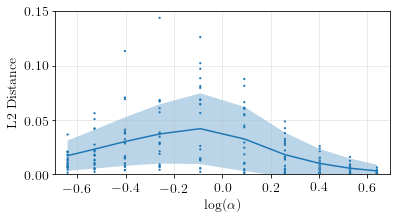

In [21]:
## plots and saves the computed similarity matrix
import os
output_dir = './out/transform_effect_plots/'
savefile = 'zoom_aug_argminW_transform_effect_plots'

alphas = alphas_no_log

xlabel = r'$\alpha$'
if np.min(alphas) > 0:
    alphas = np.log(alphas)
    xlabel = r'$\log(\alpha)$'
    
f, ax = plt.subplots(figsize=(6, 3))
xaxis = np.mean([alphas[:-1], alphas[1:]], axis=0)
mu = np.mean(dist_info, axis=0)
sd = np.std(dist_info, axis=0)
p = ax.plot(xaxis, mu)
ax.fill_between(xaxis, mu-sd, mu+sd, alpha=0.3)
xscatter = np.tile(xaxis, (20, 1))
yscatter = dist_info[:20] # take the first 20 samples
ax.scatter(xscatter, yscatter, marker='.',
           edgecolors='none', s=20, color=p[0].get_color())
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

# ax.set_ylim([0, 0.8])
ax.set_ylim([0, 0.15])
ax.grid(alpha=0.3)
# ax.set_xlim([np.min(alphas), np.max(alphas)])
ax.set_xlim([np.min(alphas), np.max(alphas)])

for (x, m, s) in zip(xaxis, mu, sd):
    print("alpha: {:.2f}, dist {:.2f} +/- {:.2f}".format(x, m, s))

f.savefig(os.path.join(output_dir, savefile + '.png'),
          bbox_inches="tight", pad_inches=0)
f.savefig(os.path.join(output_dir, savefile + '.pdf'),
          bbox_inches="tight", pad_inches=0)

alpha: -0.69, dist 0.11 +/- 0.02
alpha: -0.59, dist 0.12 +/- 0.02
alpha: -0.47, dist 0.09 +/- 0.02
alpha: -0.34, dist 0.05 +/- 0.01
alpha: -0.18, dist 0.03 +/- 0.01
alpha: 0.00, dist 0.00 +/- 0.00
alpha: 0.18, dist 0.02 +/- 0.00
alpha: 0.34, dist 0.04 +/- 0.01
alpha: 0.47, dist 0.05 +/- 0.01
alpha: 0.59, dist 0.06 +/- 0.01
alpha: 0.69, dist 0.08 +/- 0.01


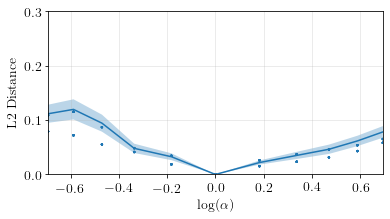

In [22]:
## plots and saves the computed similarity matrix
import os
output_dir = './out/transform_effect_plots/'
savefile = 'zoom_aug_argminW_loss_trained_plots'

alphas = alphas_no_log

xlabel = r'$\alpha$'
if np.min(alphas) > 0:
    alphas = np.log(alphas)
    xlabel = r'$\log(\alpha)$'
    
f, ax = plt.subplots(figsize=(6, 3))
# xaxis = np.mean([alphas[:-1], alphas[1:]], axis=0)
xaxis = np.mean([alphas[:], alphas[:]], axis=0)
mu = np.mean(dist_trained_info, axis=0)
sd = np.std(dist_trained_info, axis=0)
p = ax.plot(xaxis, mu)
ax.fill_between(xaxis, mu-sd, mu+sd, alpha=0.3)
xscatter = np.tile(xaxis, (20, 1))
yscatter = dist_trained_info[:20] # take the first 20 samples
ax.scatter(xscatter, yscatter, marker='.',
           edgecolors='none', s=20, color=p[0].get_color())
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

# ax.set_ylim([0, 0.8])
ax.set_ylim([0, 0.3])
ax.grid(alpha=0.3)
# ax.set_xlim([np.min(alphas), np.max(alphas)])
ax.set_xlim([np.min(alphas), np.max(alphas)])

for (x, m, s) in zip(xaxis, mu, sd):
    print("alpha: {:.2f}, dist {:.2f} +/- {:.2f}".format(x, m, s))

f.savefig(os.path.join(output_dir, savefile + '.png'),
          bbox_inches="tight", pad_inches=0)
f.savefig(os.path.join(output_dir, savefile + '.pdf'),
          bbox_inches="tight", pad_inches=0)